This notebook consists of three parts, which are DenseNet121, ResNet50 and the data augmentation techniques.

## Preparation Work

Pre-requisites:


In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install h5py

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import random 
import pickle
import cv2
import numpy as np


Downloading and decompressing the Appa-Real Age Dataset

In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data.zip

--2021-09-29 12:09:06--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799021037 (762M) [application/zip]
Saving to: ‘app_data.zip’

app_data.zip        100%[===================>] 762.00M  16.4MB/s    in 51s     

2021-09-29 12:09:58 (14.9 MB/s) - ‘app_data.zip’ saved [799021037/799021037]

Data decompressed successfully


Loading the train/validation data, and re-scaling the labels to [0..1]

In [ ]:
import numpy as np

# loading the train data
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate 
                      # them using the raw data, i.e., the apparent age values

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)
print('Test metadata size and shape', M_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)
Test metadata size and shape (1978, 3)


## Part 1 Test with DenseNet121


Preprocessing

In [ ]:

# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.densenet.preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf.keras.applications.densenet.preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.densenet.preprocess_input(x)  

Loading the DenseNet121

In [ ]:
b_model=tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",input_tensor=None,input_shape=(224, 224, 3),pooling='avg')
#print(b_model.summary())

29097984/29084464 [==============================] - 0s 0us/step


Constructing extra layers

fc_512 , fc_128, fc_32, fc_8

fc_512, fc_128, fc_32, fc_16

fc_512 , fc_128, fc_32, fc_16, fc_8

fc_512 , fc_64, fc_16, fc_8

fc_512 , fc_256, fc_64, fc_16, fc_8

fc_512 , dp(0.5), fc_256, dp(0.5), fc_64, fc_16, fc_8

fc_512 , dp(0.5), fc_64 , fc_16 , fc_8

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc = b_model.output
# adding a few hidden FC layers to learn hidden representations
fc_512 = Dense(512, activation='relu', name='f_512')(fc)
# adding a dropout layer to minimize overfiting problems
#dp_layer = Dropout(0.5)(fc_512)
fc_128 = Dense(128, activation='relu', name='f_128')(fc_512)
fc_32 = Dense(32, activation='relu', name='f_32')(fc_128)
#fc_16 = Dense(16, activation='relu', name='f_16')(fc_32)
#fc_8 = Dense(8, activation='relu', name='f_8')(fc_16)
# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and pringing the final model
model_121= Model(inputs=b_model.input,outputs=output)
print(model_121.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Stage 1 freezing some layers

Freezing 427 layers

Freezing 312 layers

Freezing 99 layers

In [ ]:
# Freezing the first layers
counter = 0
for layer in model_121.layers:
  if counter <= 427: 
    layer.trainable = False
  else:
    layer.trainable = True
  #print(counter, layer.name, layer.trainable)
  #counter +=1

Mounting

In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.

Training at Stage 1


Hyperparameters tuning:all the hyperparameters tuned are presented below:

choose of learning rate: 1e-5, 5e-5, 1e-4, 1e-3

batch size: 10,32, 64 in stage 1, 5,16 in stage 2

numbers of epochs:25,80 in stage 1,   6, 10,12,15,20 in stage 2


loss function: MSE, MAE, Huber loss

optimizer: Adam, SGD

In [ ]:
# defining the early stop criteria
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/model_121.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,decay_steps=10000,decay_rate=0.01)
model_121.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model_121.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=64, epochs=80, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/temp/train_121_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Ploting Stage 1 training history

In [ ]:

train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_121_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

Testing on stage 1

In [ ]:
saved_model = load_model('/content/gdrive/MyDrive/temp/model_121.h5')

predictions_st1 = saved_model.predict(X_test, batch_size=32, verbose=1)

predictions_st1_f = predictions_st1*100

# evaluating on test data
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st1_f[i][0],Y_test[i])))

print('MAE = %.8f' %(np.mean(error)))

Training on stage 2

In [ ]:
# setting all layers of the model to trainable

saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  print(counter, layer.name, layer.trainable)
  counter +=1

# training all layers (2nd stage), given the model saved on stage 1
#lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,decay_steps=10000,decay_rate=0.01)
saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# defining the early stop criteria
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model (2nd stage) based on val_loss with a different name
mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/model_121_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=20, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history
with open('/content/gdrive/MyDrive/temp/train_121_history_2nd_stage.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



Ploting training history of stage 1 and stage 2

In [ ]:
train_hist = pickle.load(open('/content/gdrive/MyDrive/temp/train_121_history.pkl',"rb"))
train_hist_2nd = pickle.load(open('/content/gdrive/MyDrive/temp/train_121_history_2nd_stage.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.axvline(6, 0, 1, ls='--', color='r')
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.axvline(6, 0, 1, ls='--', color='r')
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

Testing on stage 2

In [ ]:
saved_model_2nd = load_model('/content/gdrive/MyDrive/temp/model_121_2nd_stage.h5')

# predict on the test data
predictions_2nd = saved_model_2nd.predict(X_test, batch_size=32, verbose=1)

# re-scaling the output predictions (from [0,1] to age range) using the
# the normalization factor mentioned before
predictions_2nd_f = predictions_2nd*100
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_2nd_f[i][0],Y_test[i])))

print('MAE = %.8f' %(np.mean(error)))

Bias Evaluation 

In [ ]:
# Age Bias ( 𝐵𝑎 )
def age_bias(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))

  age_bias = (abs(np.mean(error_g1)-np.mean(error_g2)) +
            abs(np.mean(error_g1)-np.mean(error_g3)) +
            abs(np.mean(error_g1)-np.mean(error_g4)) +
            abs(np.mean(error_g2)-np.mean(error_g3)) +
            abs(np.mean(error_g2)-np.mean(error_g4)) +
            abs(np.mean(error_g3)-np.mean(error_g4)))/6

  print('---------')
  print('Age bias (Ba) = ', age_bias)


# Gender Bias ( 𝐵𝑔 )
def gender_bias(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  gender_bias = abs(np.mean(error_f)-np.mean(error_m))

  print('---------')
  print('Gender bias (Bg) = ', gender_bias)

# Ethnicity Bias ( 𝐵𝑒 )
def ethnicity_bias(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  
  ethnicity_bias = (abs(np.mean(error_as)-np.mean(error_af)) +
                   abs(np.mean(error_as)-np.mean(error_ca)) +
                   abs(np.mean(error_af)-np.mean(error_ca)))/3

  print('---------')
  print('Ethnicity bias (Be) = ', ethnicity_bias)


#Face expression bias ( 𝐵𝑓 )
def face_expression_bias(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))

  face_bias = (abs(np.mean(error_h)-np.mean(error_s)) +
              abs(np.mean(error_h)-np.mean(error_n)) +
              abs(np.mean(error_h)-np.mean(error_o)) +
              abs(np.mean(error_s)-np.mean(error_n)) +
              abs(np.mean(error_s)-np.mean(error_o)) +
              abs(np.mean(error_n)-np.mean(error_o)))/6

  print('---------')
  print('Face Expression bias (Bf) = ', face_bias)

Computing the Age, Gender and Ethnicity Biases on the Test set

In [ ]:

# computing the age bias (model_stage_2)
age_bias(predictions_2nd_f,Y_test)

# computing the gender bias (model_stage_2)
gender_bias(predictions_2nd_f,Y_test,M_test)

# computing the ethnicity bias (model_stage_2)
ethnicity_bias(predictions_2nd_f,Y_test,M_test)

# computing the face bias (model_stage_2)
face_expression_bias(predictions_2nd_f,Y_test,M_test)

Save predictions

In [ ]:
# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_2nd_f)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

## Part 2 Test with ResNet50



>    **Training Strategy**: stage 1 => stage 2







**Preprocessing**

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = preprocess_input(x) 

**Downloading the ResNet50 model pre-trained on Faces**

In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

--2021-09-29 12:10:49--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip.1’

model.zip.1         100%[===================>] 102.89M  17.5MB/s    in 6.9s    

2021-09-29 12:10:56 (15.0 MB/s) - ‘model.zip.1’ saved [107893665/107893665]

Model decompressed successfully


**Loading the pre-trained model**

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# print the model summary
# print(model.summary())

**Adapting the model to our needs**

*Model architectures of extra hidden layers*: we add more hidden layers after the “dim_proj” layer(512-neuron FC layer) in ResNets50.
*   fc_512 => fc_128 + fc_32 => fc_1
*   fc_512 => fc_128 + fc_32 + fc_8 => fc_1
*   fc_512 => fc_64 + fc_16 + fc_8 => fc_1
*   fc_512 => fc_256 + fc_64 + fc_8 => fc_1
*   fc_512 => fc_256 + fc_64 + fc_16 + fc_8 => fc_1
*   fc_512 => dp(0.5) + fc_256 + dp(0.5) + fc_64 + fc_16 + fc_8 => fc_1
*   fc_512 => dp(0.5) + fc_64 + fc_16 + fc_8 => fc_1

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems (or not)
# dp_512 = Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
'''
fc_128 = Dense(128, activation='relu', name='f_128')(fc_512)
fc_32 = Dense(32, activation='relu', name='f_32')(fc_128)
fc_8 = Dense(8, activation='relu', name='f_8')(fc_32)
fc_256 = Dense(256, activation='relu', name='f_256')(dp_512)
dp_256 = Dropout(0.5)(fc_256)
'''
fc_64 = Dense(64, activation='relu', name='f_64')(fc_512)
fc_16 = Dense(16, activation='relu', name='f_16')(fc_64)
fc_8 = Dense(8, activation='relu', name='f_8')(fc_16)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = Dense(1, activation='sigmoid', name='predict')(fc_8)

# building and pringing the final model
model = Model(inputs=model.get_layer('base_input').output,outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

**Freezing the first layers to allow the fine-tuning of the last FC layers**

**Two freezing strategies**: (1) freezing the first **174** layers(the whole ResNets without FC layer) or (2) freezing the first **133** layers of backbones, and training the rest of network.

In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174:   #  using 174 or 133
    layer.trainable = False
  else:
    layer.trainable = True
  # print(counter, layer.name, layer.trainable)
  counter +=1

**Training the Model for stage 1**

*Hyperparameters tuning:*all the hyperparameters tuned are presented below:
*   **choose of learning rate**: 1e-5, 5e-5, 1e-4, 1e-3
*   **batch size**: 32 or 64 in stage 1, 16 in stage 2
*   **numbers of epochs**: adjustment and setting according to the training process. It's worth noting that due to imbalance of our data set, we can observe from the the MSE curve and the loss curve plotted that they fluctuated more and more in the latter part of the training, which means that neural network face the problem of overfitting and introduce the higher bias and lower accuration.
*   **loss function**: MSE, MAE, Huber loss
*   **optimizer**: Adam, SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
# load a model and train history
#--------------------------
LOAD_BEST_MODEL_ST1 = False # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  
else:
  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = ModelCheckpoint('/content/drive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae']) #loss=tf.keras.losses.MeanSquaredError()loss=tf.keras.losses.Huber()

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/drive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/30
481/481 [==============================] - 141s 218ms/step - loss: 0.2260 - mae: 0.1732 - val_loss: 0.2103 - val_mae: 0.1401


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
481/481 [==============================] - 102s 211ms/step - loss: 0.2105 - mae: 0.1408 - val_loss: 0.2058 - val_mae: 0.1305
Epoch 3/30
481/481 [==============================] - 102s 212ms/step - loss: 0.2063 - mae: 0.1308 - val_loss: 0.2036 - val_mae: 0.1249
Epoch 4/30
481/481 [==============================] - 102s 212ms/step - loss: 0.2036 - mae: 0.1240 - val_loss: 0.2019 - val_mae: 0.1205
Epoch 5/30
481/481 [==============================] - 102s 212ms/step - loss: 0.2018 - mae: 0.1188 - val_loss: 0.2007 - val_mae: 0.1167
Epoch 6/30
481/481 [==============================] - 102s 213ms/step - loss: 0.2004 - mae: 0.1146 - val_loss: 0.2002 - val_mae: 0.1152
Epoch 7/30
481/481 [==============================] - 102s 212ms/step - loss: 0.1992 - mae: 0.1111 - val_loss: 0.1995 - val_mae: 0.1132
Epoch 8/30
481/481 [==============================] - 102s 212ms/step - loss: 0.1982 - mae: 0.1080 - val_loss: 0.1991 - val_mae: 0.1120
Epoch 9/30
481/481 [============================

**Visualizing the train history for stage 1**


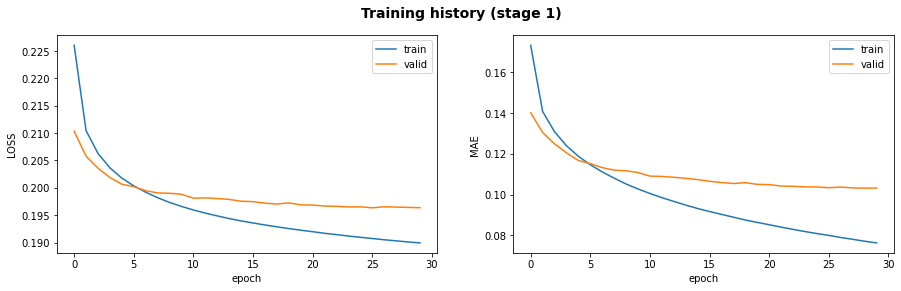

In [ ]:
import pickle
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the 
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/drive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')  

**Loading the saved model and Making predictions on the Test set**

In [ ]:
from tensorflow.keras.models import load_model

#--------------------------
ENABLE_EVALUATION_ST1 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST1==True):
  saved_model = load_model('best_model.h5')
else:
  saved_model = load_model('/content/drive/MyDrive/temp/best_model.h5')

if(ENABLE_EVALUATION_ST1==True):
  # predict on the test data
  predictions_st1 = saved_model.predict(X_test, batch_size=32, verbose=1)

62/62 [==============================] - 13s 205ms/step


**Evaluating the model on the Test set with MAE**

In [ ]:
if(ENABLE_EVALUATION_ST1==True):
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st1_f = predictions_st1*100

  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_st1_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 11.00527027


**Performing a 2nd Stage of training**

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  # print(counter, layer.name, layer.trainable)
  counter +=1

In [ ]:
# Loding a pretrained model or train
#--------------------------
LOAD_BEST_MODEL_ST2 = False
#--------------------------

if(LOAD_BEST_MODEL_ST2==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
  # decompressing the data
  with ZipFile('best_model_st2.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2.zip

else:
  
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.MeanSquaredError(),metrics=['mae']) # loss=tf.keras.losses.MeanSquaredError() loss=tf.keras.losses.Huber()

  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = ModelCheckpoint('/content/drive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=10, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/drive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/6
962/962 [==============================] - 380s 386ms/step - loss: 0.1906 - mae: 0.0924 - val_loss: 0.1795 - val_mae: 0.0725


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/6
962/962 [==============================] - 369s 383ms/step - loss: 0.1689 - mae: 0.0636 - val_loss: 0.1611 - val_mae: 0.0689
Epoch 3/6
962/962 [==============================] - 368s 382ms/step - loss: 0.1469 - mae: 0.0516 - val_loss: 0.1376 - val_mae: 0.0602
Epoch 4/6
962/962 [==============================] - 370s 385ms/step - loss: 0.1246 - mae: 0.0469 - val_loss: 0.1157 - val_mae: 0.0563
Epoch 5/6
962/962 [==============================] - 370s 384ms/step - loss: 0.1044 - mae: 0.0470 - val_loss: 0.0977 - val_mae: 0.0613
Epoch 6/6
962/962 [==============================] - 369s 384ms/step - loss: 0.0870 - mae: 0.0447 - val_loss: 0.0875 - val_mae: 0.0813


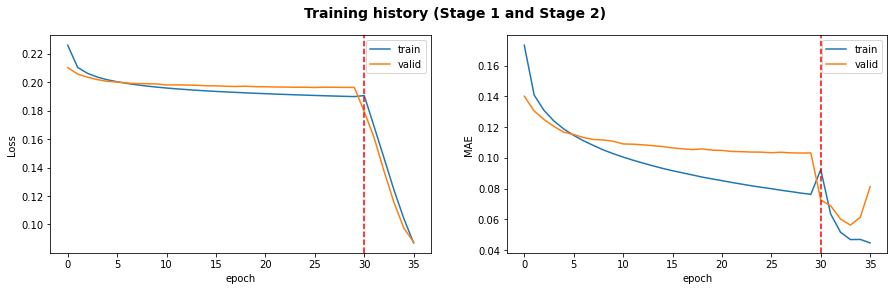

In [ ]:
## Visualizing the Training history of both stages (1st stage and 2nd stage)

if(LOAD_BEST_MODEL_ST1==False and LOAD_BEST_MODEL_ST2==False):
  train_hist = pickle.load(open("/content/drive/MyDrive/temp/train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("/content/drive/MyDrive/temp/train_history_2nd_stage.pkl","rb"))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
  fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

  ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
  ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
  ax1.axvline(30, 0, 1, ls='--', color='r')
  ax1.set(xlabel='epoch', ylabel='Loss')
  ax1.legend(['train', 'valid'], loc='upper right')

  ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
  ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
  ax2.axvline(30, 0, 1, ls='--', color='r')
  ax2.set(xlabel='epoch', ylabel='MAE')
  ax2.legend(['train', 'valid'], loc='upper right')

**Evaluating the model lerned at the 2nd stage on the test set**

In [ ]:
#--------------------------
ENABLE_EVALUATION_ST2 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST2 == True):
  saved_model_2nd = load_model('best_model_2nd_stage.h5')
else:
  saved_model_2nd = load_model('/content/drive/MyDrive/temp/best_model_2nd_stage.h5')


if(ENABLE_EVALUATION_ST2==True):
  # predict on the test data
  predictions_2nd = saved_model_2nd.predict(X_test, batch_size=32, verbose=1)

  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_2nd_f = predictions_2nd*100

62/62 [==============================] - 12s 182ms/step


In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_2nd_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 9.66914241


**Four Bias**

In [ ]:
def age_bias(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))

  age_bias = (abs(np.mean(error_g1)-np.mean(error_g2)) +
            abs(np.mean(error_g1)-np.mean(error_g3)) +
            abs(np.mean(error_g1)-np.mean(error_g4)) +
            abs(np.mean(error_g2)-np.mean(error_g3)) +
            abs(np.mean(error_g2)-np.mean(error_g4)) +
            abs(np.mean(error_g3)-np.mean(error_g4)))/6

  print('---------')
  print('Age bias (Ba) = ', age_bias)

In [ ]:
def gender_bias(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  gender_bias = abs(np.mean(error_f)-np.mean(error_m))

  print('---------')
  print('Gender bias (Bg) = ', gender_bias)

In [ ]:
def ethnicity_bias(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  
  ethnicity_bias = (abs(np.mean(error_as)-np.mean(error_af)) +
                   abs(np.mean(error_as)-np.mean(error_ca)) +
                   abs(np.mean(error_af)-np.mean(error_ca)))/3

  print('---------')
  print('Ethnicity bias (Be) = ', ethnicity_bias)

In [ ]:
def face_expression_bias(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))

  face_bias = (abs(np.mean(error_h)-np.mean(error_s)) +
              abs(np.mean(error_h)-np.mean(error_n)) +
              abs(np.mean(error_h)-np.mean(error_o)) +
              abs(np.mean(error_s)-np.mean(error_n)) +
              abs(np.mean(error_s)-np.mean(error_o)) +
              abs(np.mean(error_n)-np.mean(error_o)))/6

  print('---------')
  print('Face Expression bias (Bf) = ', face_bias)

**Computing the Age, Gender and Ethnicity Biases on the Test set**

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2)
  age_bias(predictions_2nd_f,Y_test)

  # computing the gender bias (model_stage_2)
  gender_bias(predictions_2nd_f,Y_test,M_test)

  # computing the ethnicity bias (model_stage_2)
  ethnicity_bias(predictions_2nd_f,Y_test,M_test)

  # computing the face bias (model_stage_2)
  face_expression_bias(predictions_2nd_f,Y_test,M_test)

Age analysis:
Size group 1 = 369, MAE = 8.728218
Size group 2 = 1044, MAE = 7.555730
Size group 3 = 390, MAE = 10.551334
Size group 4 = 175, MAE = 22.295134
---------
Age bias (Ba) =  7.673553466796875
Gender analysis:
Size group female = 1020, MAE = 9.700359
Size group male = 958, MAE = 9.635905
---------
Gender bias (Bg) =  0.06445408
Ethnicity Analysis:
Size group asian = 129, MAE = 8.688550
Size group afroamerican = 56, MAE = 8.821015
Size group caucasian = 1793, MAE = 9.766182
---------
Ethnicity bias (Be) =  0.7184213002522787
Face experession Analysis:
Size group happy = 589, MAE = 9.633095
Size group slightlyhappy = 505, MAE = 9.784475
Size group neutral = 756, MAE = 9.484666
Size group other = 128, MAE = 10.469562
---------
Face Expression bias (Bf) =  0.5176779429117838


**Saving the predicted values (on Test set) to be uploaded on Codalab Competition**

In [ ]:
import csv

if(ENABLE_EVALUATION_ST2==True):
  # saving the predictions as a csv file
  with open('predictions.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(predictions_2nd_f)
  csvFile.close()

  # compressing the csv file (to be submitted to codalab as prediction)
  ! zip predictions.zip predictions.csv

  adding: predictions.csv (deflated 55%)


**With data augmentation techniques**

In [ ]:
aug_stra_12=True

if(aug_stra_12==True):
  print("Augmented 12")
  # aux variables
  X_train_augmented = []
  Y_train_augmented = []

  # loading the train data and labels
  X_train = np.load('./data/data_train.npy')
  Y_train = np.load('./data/labels_train.npy')
  Y_train = Y_train/100

  # augmenting the data 
  for i in range(0,len(X_train)):
    # check iff conditions met

    if (Y_train[i]*100>=60 or M_train[i][1]!="caucasian" or M_train[i][2]=="happy" or M_train[i][2]=="other"): 
      # flip
      X_train_augmented.append(cv2.flip(X_train[i], 1))
      Y_train_augmented.append(Y_train[i]) 

      #flip vertically
      X_train_augmented.append(cv2.flip(X_train[i], 0))
      Y_train_augmented.append(Y_train[i])

      # 45 degree rotation
      rows, cols ,c= X_train[i].shape
      M = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1)
      X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
      Y_train_augmented.append(Y_train[i])

      # changing brightness
      x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
      x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
      X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
      Y_train_augmented.append(Y_train[i]) 

      # blur
      X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
      Y_train_augmented.append(Y_train[i])
    
      # translation
      rows, cols ,c= X_train[i].shape
      M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
      X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
      Y_train_augmented.append(Y_train[i])

      # affine transform
      point1 = np.float32([[50, 50], [300, 50], [50, 200]])
      point2 = np.float32([[10, 80], [300, 50], [100, 250]])
      M = cv2.getAffineTransform(point1, point2)
      X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows), borderValue=(255, 255, 255)))
      Y_train_augmented.append(Y_train[i])

      # Histogram equalisation
      grayimg = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
      X_train_augmented.append(cv2.cvtColor(cv2.equalizeHist(grayimg), cv2.COLOR_GRAY2RGB))
      Y_train_augmented.append(Y_train[i])

  # adding the augmented images to the train set
  X_train = np.concatenate((X_train, X_train_augmented))
  Y_train = np.concatenate((Y_train, Y_train_augmented))

Augmented 12


In [ ]:
# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

In [ ]:
print('Train set after augmentation = ', np.array(X_train).shape)

Train set after augmentation =  (15377, 224, 224, 3)


# Part 3 Augmentation Techniques
This cell contains all the executions done for the data augmentation procedures and a final plot to see the image transformations. The original codes would go from 0 to len(X_train) but in this case we transform the first image and see the results. It is important to point out that most of the conditons have been used twice, but with different augmentation techniques, for example, augmentations 1 and 7 have same conditions but 1 had only the techniques provided by the teachers and 7 got those ones and the extra ones. 13 got directly all the extra ones due to time constraints. The most important ones are 11,12 and 13 whose strategies are

*   Expand the “+60” age group regarding age, and in the expression groups “happy” and “other” with original augmentation techniques provided by teachers but adding flip verticality, 45º rotation, affine translation and histogram equalization.
*   Same as before but expanding also the “afroamerican” and “asian” groups.
*   Augment age groups 8-12 and +15 if not caucasian, augment +40 age groups if “happy” and augment the “other” expression group with all augmentation techniques.


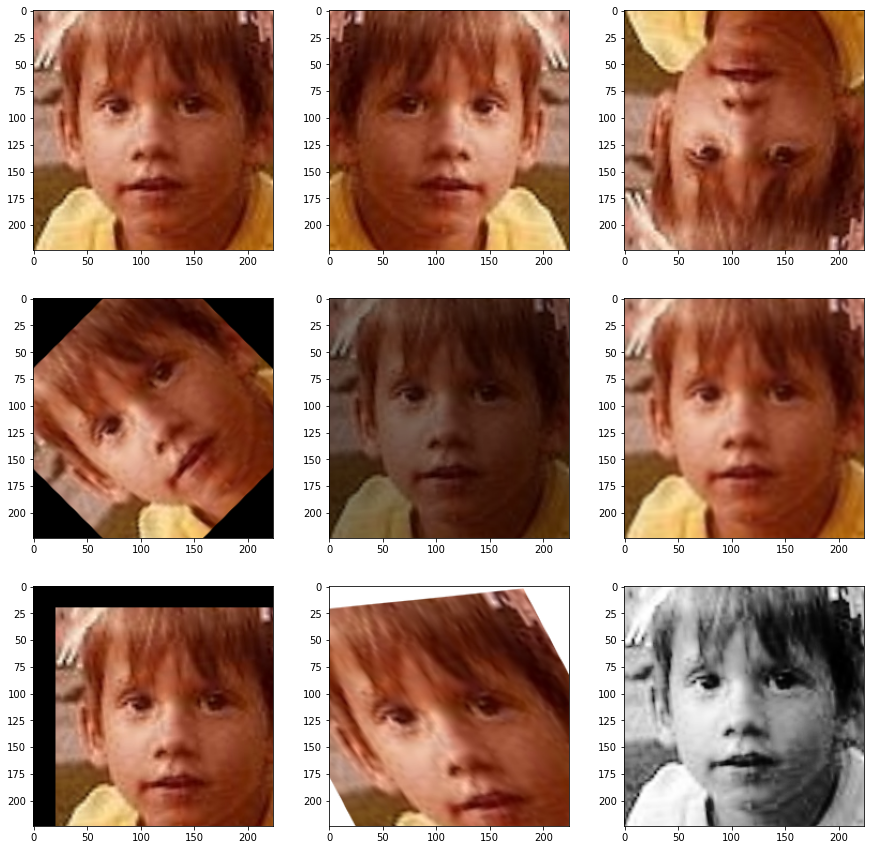

In [ ]:

# aux variables
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

# loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
M_train = np.load('./data/meta_data_train.npy')

# augmenting the data 
#for i in range(0,len(X_train)):
for i in range(0,1): #Keep code simple

  # check iff conditions met
  #if Y_train[i]*100>=60: #Augmentation 1 and 7 conditions (different approach)
  #if M_train[i][1]!="caucasian": #Augmentation 2 and 8 conditions (different approach)
  #if (M_train[i][2]=="happy" or M_train[i][2]=="other"): #Augmentation 3 and 9 conditions (different approach)
  #if (Y_train[i]*100>=60 or M_train[i][1]!="caucasian"):  #Augmentation 4 and 10 conditions (different approach)
  #if (Y_train[i]*100>=60 or M_train[i][2]=="happy" or M_train[i][2]=="other"): #Augmentation 5 and 11 conditions (different approach)
  #if (Y_train[i]*100>=60 or M_train[i][1]!="caucasian" or (M_train[i][2]=="happy" or M_train[i][2]=="other")): #Augmentation 6 and 12 conditions (different approach)
  #if (((Y_train[i]*100>=45) and (str(M_train[i][2]).lower()=="happy")) or (Y_train[i]*100>=15 and str(M_train[i][1]).lower() !='caucasian') or (Y_train[i]*100>=8 and Y_train[i]*100<=12 and str(M_train[i][1]).lower() !='caucasian') or (str(M_train[i][2]).lower()=="other")):  #Augmentation 13

  #------------GIVEN BY TEACHER----------------#
  #original
  x=X_train[i]
  # flip
  x_flipped1=cv2.flip(x, 1)
  X_train_augmented.append(x_flipped1)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])
  

  # changing brightness
  x_aux = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
  x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
  x_bright=cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB)
  X_train_augmented.append(x_bright)
  Y_train_augmented.append(Y_train[i]) 
  M_train_augmented.append(M_train[i])
  

  # blur
  x_blur=cv2.GaussianBlur(x,(5,5),1.0)
  X_train_augmented.append(x_blur)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])
  

  # translation
  rows, cols ,c= X_train[i].shape
  M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
  x_translate=cv2.warpAffine(x, M, (cols, rows))
  X_train_augmented.append(x_translate)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])

  #------------EXTRA----------------#

  #flip vertically
  x_flipped2=cv2.flip(X_train[i], 0)
  X_train_augmented.append(cv2.flip(X_train[i], 0))
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])
  

  # 45 degree rotation
  rows, cols ,c= X_train[i].shape
  M = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1)
  x_rot=cv2.warpAffine(X_train[i], M, (cols, rows))
  X_train_augmented.append(x_rot)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])
  

  # affine transform
  point1 = np.float32([[50, 50], [300, 50], [50, 200]])
  point2 = np.float32([[10, 80], [300, 50], [100, 250]])
  M = cv2.getAffineTransform(point1, point2)
  x_dst=cv2.warpAffine(X_train[i], M, (cols, rows), borderValue=(255, 255, 255))
  X_train_augmented.append(x_dst)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])
  

  # Histogram equalisation
  grayimg = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
  x_hist_plt = cv2.equalizeHist(grayimg) #This one is for plot
  x_hist = cv2.cvtColor(cv2.equalizeHist(grayimg), cv2.COLOR_GRAY2RGB) #The one that will be concatenated
  X_train_augmented.append(x_hist)
  Y_train_augmented.append(Y_train[i])
  M_train_augmented.append(M_train[i])

  #-----This is for ploting purposes-----#
  fig, axs = plt.subplots(3, 3, figsize=(15, 15))
  axs[0][0].imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
  axs[0][1].imshow(cv2.cvtColor(x_flipped1, cv2.COLOR_BGR2RGB)) # flip horizontaly
  axs[0][2].imshow(cv2.cvtColor(x_flipped2, cv2.COLOR_BGR2RGB)) # flip vertically
  axs[1][0].imshow(cv2.cvtColor(x_rot, cv2.COLOR_BGR2RGB)) # rotation 45 degree
  axs[1][1].imshow(cv2.cvtColor(x_bright, cv2.COLOR_BGR2RGB)) # change brightness
  axs[1][2].imshow(cv2.cvtColor(x_blur, cv2.COLOR_BGR2RGB))  # gaussian blur
  axs[2][0].imshow(cv2.cvtColor(x_translate, cv2.COLOR_BGR2RGB)) # translation
  axs[2][1].imshow(cv2.cvtColor(x_dst, cv2.COLOR_BGR2RGB)) # affine transform
  axs[2][2].imshow(cv2.cvtColor(x_hist_plt, cv2.COLOR_GRAY2RGB)) # Histogram equalisation
    

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))

#AND WE WOULD MOVE ON TO TRAIN THE MODELS
